In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib
import seaborn as sns

from scipy import stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

sns.set(style='darkgrid')

Using matplotlib backend: MacOSX


In [2]:
df=pd.read_csv('kc_house_data.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df['sale_month'] = df['date'].map(lambda x: x.month)

In [5]:
df=df.drop(['id','date'],axis=1)

In [6]:
# Replace '?' with '0'.
df['sqft_basement']=df['sqft_basement'].map(lambda x:float(x.replace('?', '0')))


In [7]:
#Replace 0 with difference between sqft_above and sqft_living
df['sqft_basement'].replace(to_replace='0', value = abs(df['sqft_living']-df['sqft_above']), inplace=True)


In [8]:
# Change 33 bedrooms to 3 bedrooms.
df['bedrooms'].replace(to_replace=33, value =3, inplace=True)


In [9]:
df['view'].fillna(0,inplace=True)

In [10]:
df['waterfront'].fillna(0,inplace=True)

In [11]:
df.yr_renovated.fillna(0, inplace=True)

In [12]:
Q1 = df.quantile(0.001)
Q3 = df.quantile(0.999)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [13]:
non_normal = ['price','sqft_living', 'sqft_lot','sqft_above','sqft_basement',
              'yr_built', 'yr_renovated','sqft_living15', 'sqft_lot15']
for feat in non_normal:
    df[feat] = df[feat].map(lambda x: np.log1p(x))


In [14]:
def norm_feat(series):
    return (series - series.mean())/series.std()
for feat in ['bathrooms', 'sqft_living', 'sqft_lot','sqft_above', 'sqft_basement', 'yr_built','yr_renovated','sqft_living15', 'sqft_lot15']:
    df[feat] = norm_feat(df[feat])


In [15]:
df['bedrooms'] = df['bedrooms'].astype('category')
df['floors'] = df['floors'].astype('category')
df['waterfront'] = df['waterfront'].astype('category')
df['view'] = df['view'].astype('category')
df['condition'] = df['condition'].astype('category')
df['grade'] = df['grade'].astype('category')
df['zipcode'] = df['zipcode'].astype('category')
df['sale_month'] = df['sale_month'].astype('category')


In [16]:
feats = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'sale_month']
df_feats = df[feats]
df_feats_zipcode=df_feats.copy()
df_feats = pd.get_dummies(df_feats, drop_first=True)

In [17]:
df_feats.columns = df_feats.columns.str.replace(r"[.]", "_")

In [18]:
outcome = 'price'
x_cols = ['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5',
       'bedrooms_6', 'bedrooms_7', 'bedrooms_8', 'bedrooms_9', 'bedrooms_10',
       'bedrooms_11', 'floors_1_5', 'floors_2_0', 'floors_2_5',
       'floors_3_0', 'floors_3_5', 'waterfront_1_0', 'view_1_0', 'view_2_0',
       'view_3_0', 'view_4_0', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13']

In [19]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_feats).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     1017.
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        21:26:20   Log-Likelihood:                -4818.2
No. Observations:               21594   AIC:                             9724.
Df Residuals:                   21550   BIC:                         1.008e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.5859      0.309     40.795      0.000      11.981      13.191
bathrooms          0.0530      0.004     13.786      0.000       0.045       0.061
sqft_living        0.0792      0.010      7.861      0.000       0.059       0.099
sqft_lot          -0.0088      0.005     -1.635      0.102      -0.019       0.002
sqft_above         0.0636      0.010      6.378      0.000       0.044       0.083
sqft_basement      0.0504      0.005     10.329      0.000       0.041       0.060
yr_built          -0.1568      0.003    -47.868      0.000      -0.163      -0.150
yr_renovated       0.0073      0.002      3.333      0.001       0.003       0.012
sqft_living15      0.0898      0.004     25.650      0.000       0.083       0.097
sqft_lot15        -0.0368      0.005     -6.929      0.000      -0.047      -0.026
bedrooms_2        -0.0122      0.023     -0.530      0.596      -0.057       0.033
bedrooms_3        -0.1201      0.023     -5.174      0.000      -0.166      -0.075
bedrooms_4        -0.1479      0.024     -6.200      0.000      -0.195      -0.101
bedrooms_5        -0.1385      0.025     -5.505      0.000      -0.188      -0.089
bedrooms_6        -0.1802      0.031     -5.894      0.000      -0.240      -0.120
bedrooms_7        -0.2210      0.055     -3.998      0.000      -0.329      -0.113
bedrooms_8        -0.0545      0.088     -0.618      0.536      -0.227       0.118
bedrooms_9        -0.2526      0.127     -1.992      0.046      -0.501      -0.004
bedrooms_10       -0.0476      0.177     -0.270      0.788      -0.394       0.299
bedrooms_11       -0.3883      0.304     -1.277      0.202      -0.984       0.208
floors_1_5         0.0445      0.008      5.290      0.000       0.028       0.061
floors_2_0         0.0275      0.007      3.906      0.000       0.014       0.041
floors_2_5         0.0634      0.025      2.527      0.012       0.014       0.113
floors_3_0         0.2236      0.015     14.863      0.000       0.194       0.253
floors_3_5         0.1742      0.116      1.507      0.132      -0.052       0.401
waterfront_1_0     0.3668      0.031     11.925      0.000       0.307       0.427
view_1_0           0.1348      0.017      7.918      0.000       0.101       0.168
view_2_0           0.0698      0.010      6.757      0.000       0.050       0.090
view_3_0           0.0998      0.014      7.096      0.000       0.072       0.127
view_4_0           0.2137      0.021     10.002      0.000       0.172       0.256
condition_2        0.0370      0.061      0.606      0.545      -0.083       0.157
condition_3        0.1849      0.057      3.252      0.001       0.073       0.296
condition_4        0.2124      0.057      3.736      0.000       0.101       0.324
condition_5        0.2819      0.057      4.928      0.000       0.170       0.394
grade_4     

#### Inference from the model summary
By interpreting the model summary(OLS regression results) we can say that this model is underfit.Because it can not be a fitting model with R-squared=0.67 and too many p-values > 0.05 . Baseline model can neither model the training data nor generalize to new data. 

### Checking for Normality
We should check to ensure that our residuals are normally distributed.Q-Q plots are helpful for analyzing normality.

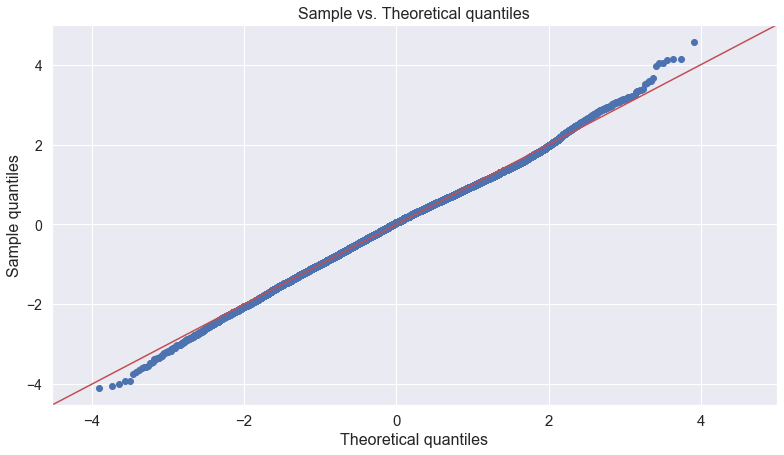

In [20]:
fig, ax = plt.subplots(figsize=(13, 7))
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax)
plt.xlabel('Theoretical quantiles', fontsize=16)
plt.ylabel('Sample quantiles', fontsize=16)
plt.title('Sample vs. Theoretical quantiles', fontsize=16)
plt.xticks(fontsize=15); plt.yticks(fontsize=14);
plt.show();


#### Inference from the Q-Q plot
Ideally, this plot should show a straight line. A curved, distorted line suggests residuals have a non-normal distribution. We need to make improve the model. 

### Checking for Homoscedasticity
A scatter plot is good way to check whether the data are homoscedastic (meaning the residuals are equal across the regression line). The residuals are equal across the regression line.

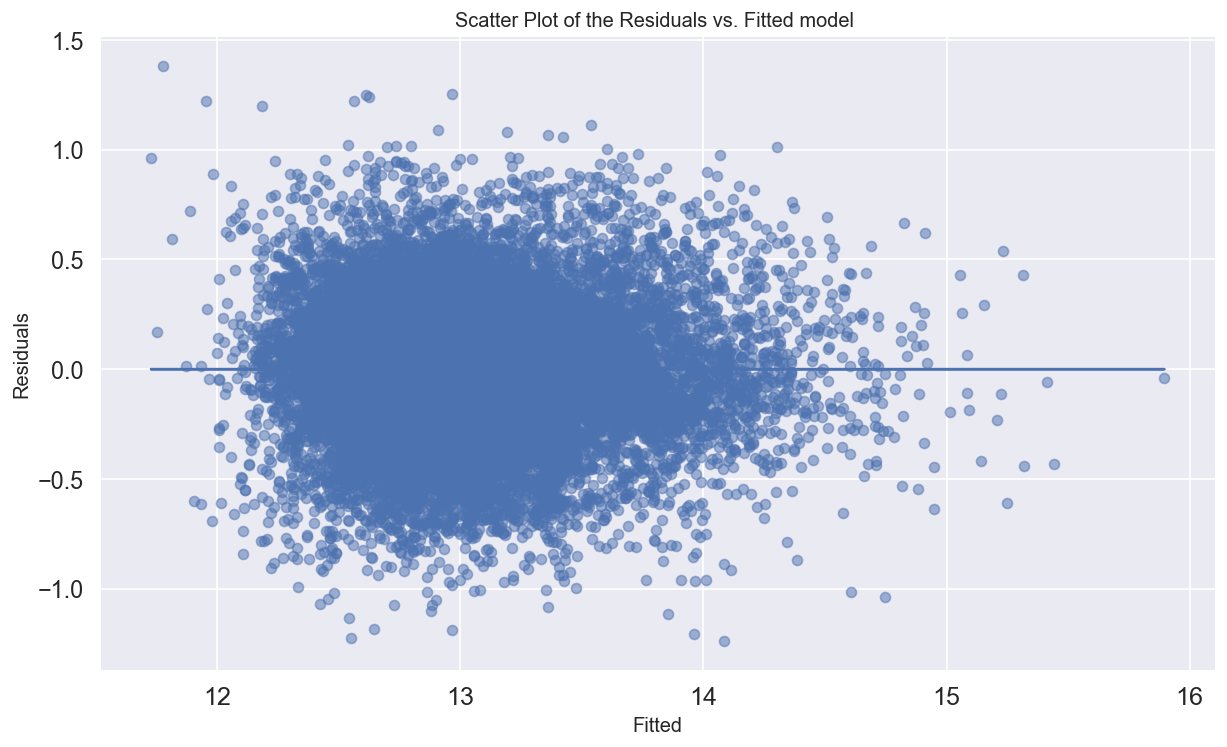

In [21]:
plt.figure(figsize=(12, 7), dpi= 120,  edgecolor='k');
plt.scatter(model.predict(df_feats[x_cols]), model.resid, alpha=0.5);
plt.plot(model.predict(df_feats[x_cols]), [0 for i in range(len(df_feats))]);
plt.gca().set(xlabel='Fitted', ylabel='Residuals',title='Scatter Plot of the Residuals vs. Fitted model ')
plt.xticks(fontsize=15); plt.yticks(fontsize=14);
plt.show();

### Checking for multicollinearity
Variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. It means that if VIF value of a parameter is higher than app.5 we need to eliminate this parameter. In this model we eliminate the parameters by using stepwise selection. We double check the results via VIF.

In [22]:
X = df_feats[x_cols]

In [23]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bathrooms', 3.4788775455774275),
 ('sqft_living', 23.922270174428856),
 ('sqft_lot', 6.890133746212493),
 ('sqft_above', 23.429425815982846),
 ('sqft_basement', 5.6074151906184),
 ('yr_built', 2.5280345132085786),
 ('yr_renovated', 1.1359543125137344),
 ('sqft_living15', 2.887170097148353),
 ('sqft_lot15', 6.65735379865336),
 ('bedrooms_2', 16.03896298731584),
 ('bedrooms_3', 57.783476017614795),
 ('bedrooms_4', 42.7331586132522),
 ('bedrooms_5', 11.059566331930569),
 ('bedrooms_6', 2.7728696004333626),
 ('bedrooms_7', 1.266865607272781),
 ('bedrooms_8', 1.103986445968317),
 ('bedrooms_9', 1.0528299896311408),
 ('bedrooms_10', 1.0220220681478296),
 ('bedrooms_11', 1.0087210082971085),
 ('floors_1_5', 1.4741111038398822),
 ('floors_2_0', 4.45028245468195),
 ('floors_2_5', 1.1048054036474821),
 ('floors_3_0', 1.5087230561740552),
 ('floors_3_5', 1.0194499729088364),
 ('waterfront_1_0', 1.5070807371705153),
 ('view_1_0', 1.0438971197309366),
 ('view_2_0', 1.1122571125748943),
 ('view_3

#### Note: 
I tried to fit this model for hours. I made 30-40 different combinations to have satisfying p-values and R-sqared values. Finally I saw that it is not possible to make a working regression model without zip code. I avoided adding 70 more columns to the data frame. I was afraid of overfitting but I coul not even overfit the data. Zip codes worked well because I had a big sample size, having more than 100 columns did not make a problem.

## Model Refinement I

We add one categorical columns of zip code and sale month.

In [24]:
outcome = 'price'
x_cols = [ 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5',
       'bedrooms_6', 'bedrooms_7', 'bedrooms_8', 'bedrooms_9', 'bedrooms_10',
       'bedrooms_11', 'floors_1_5', 'floors_2_0', 'floors_2_5', 'floors_3_0',
       'floors_3_5', 'waterfront_1_0', 'view_1_0', 'view_2_0', 'view_3_0',
       'view_4_0', 'condition_2', 'condition_3', 'condition_4', 'condition_5',
       'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9',
       'grade_10', 'grade_11', 'grade_12', 'grade_13', 'sale_month_2', 
       'sale_month_3', 'sale_month_4', 'sale_month_5', 'sale_month_6',
       'sale_month_7', 'sale_month_8', 'sale_month_9', 'sale_month_10',
       'sale_month_11', 'sale_month_12','zipcode_98002','zipcode_98014',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 
       'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024',
       'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030',
       'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034',
       'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042',
       'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055',
       'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065',
       'zipcode_98070', 'zipcode_98072', 'zipcode_98074', 'zipcode_98075',
       'zipcode_98077', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103',
       'zipcode_98105', 'zipcode_98106', 'zipcode_98107', 'zipcode_98108',
       'zipcode_98109', 'zipcode_98112', 'zipcode_98115', 'zipcode_98116',
       'zipcode_98117', 'zipcode_98118', 'zipcode_98119', 'zipcode_98122',
       'zipcode_98125', 'zipcode_98126', 'zipcode_98133', 'zipcode_98136',
       'zipcode_98144', 'zipcode_98146', 'zipcode_98148', 'zipcode_98155',
       'zipcode_98166', 'zipcode_98168', 'zipcode_98177', 'zipcode_98178',
       'zipcode_98188', 'zipcode_98198', 'zipcode_98199']


#### Fitting the model

We used stats models OLS regression. We put x.cols to the model and tried to predict the target parameter 'price'.

In [25]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_feats).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1379.
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        21:26:23   Log-Likelihood:                 6818.1
No. Observations:               21594   AIC:                        -1.339e+04
Df Residuals:                   21470   BIC:                        -1.240e+04
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.6249      0.181     69.713      0.000      12.270      12.980
bathrooms          0.0296      0.002     13.075      0.000       0.025       0.034
sqft_living        0.0999      0.006     16.843      0.000       0.088       0.111
sqft_lot           0.0652      0.003     20.227      0.000       0.059       0.071
sqft_above         0.0818      0.006     13.936      0.000       0.070       0.093
sqft_basement      0.0132      0.003      4.574      0.000       0.008       0.019
yr_built          -0.0031      0.002     -1.333      0.183      -0.008       0.001
yr_renovated       0.0129      0.001      9.930      0.000       0.010       0.015
sqft_living15      0.0484      0.002     22.251      0.000       0.044       0.053
sqft_lot15        -0.0178      0.003     -5.568      0.000      -0.024      -0.012
bedrooms_2        -0.0196      0.014     -1.450      0.147      -0.046       0.007
bedrooms_3        -0.0442      0.014     -3.243      0.001      -0.071      -0.018
bedrooms_4        -0.0470      0.014     -3.352      0.001      -0.075      -0.020
bedrooms_5        -0.0662      0.015     -4.471      0.000      -0.095      -0.037
bedrooms_6        -0.0993      0.018     -5.524      0.000      -0.135      -0.064
bedrooms_7        -0.2067      0.032     -6.378      0.000      -0.270      -0.143
bedrooms_8        -0.1198      0.052     -2.315      0.021      -0.221      -0.018
bedrooms_9        -0.2701      0.074     -3.628      0.000      -0.416      -0.124
bedrooms_10       -0.2676      0.103     -2.586      0.010      -0.470      -0.065
bedrooms_11        0.0535      0.178      0.301      0.764      -0.295       0.403
floors_1_5         0.0032      0.005      0.638      0.523      -0.007       0.013
floors_2_0        -0.0132      0.004     -3.097      0.002      -0.022      -0.005
floors_2_5         0.0039      0.015      0.265      0.791      -0.025       0.033
floors_3_0        -0.0806      0.009     -8.562      0.000      -0.099      -0.062
floors_3_5        -0.0679      0.068     -1.002      0.316      -0.201       0.065
waterfront_1_0     0.4408      0.018     24.128      0.000       0.405       0.477
view_1_0           0.1113      0.010     11.029      0.000       0.091       0.131
view_2_0           0.1010      0.006     16.391      0.000       0.089       0.113
view_3_0           0.1730      0.008     20.635      0.000       0.157       0.189
view_4_0           0.2899      0.013     22.872      0.000       0.265       0.315
condition_2        0.1503      0.036      4.200      0.000       0.080       0.220
condition_3        0.2841      0.033      8.523      0.000       0.219       0.349
condition_4        0.3258      0.033      9.768      0.000       0.260       0.391
condition_5        0.3952      0.034     11.775      0.000       0.329       0.461
grade_4     

#### Inference from the model summary
Wow! We have a good R-squared value. Adjusted R- squared value is not very different from the R-squared value because the sample size is big. We have more than 27 thousand houses to fit the model. P-values of some parameters are higher than 0.05 which decreases confidence level. We need to eliminate the columns by stepwise selection.

### Checking for Normality


We should check to ensure that our residuals are normally distributed.Q-Q plots are helpful for analyzing normality.

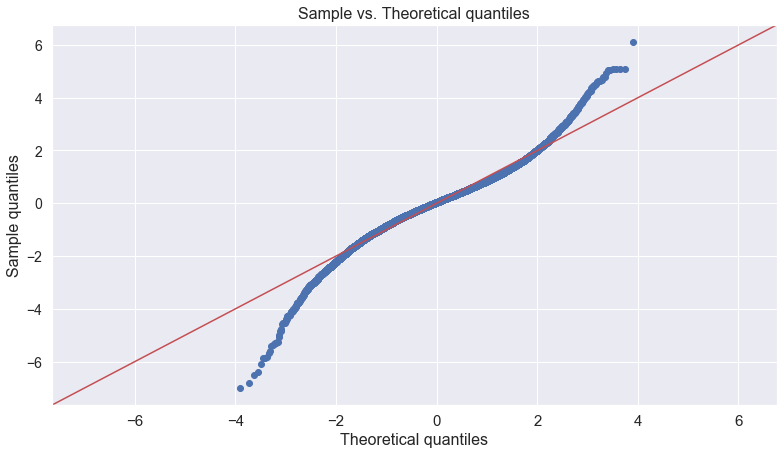

In [26]:
fig, ax = plt.subplots(figsize=(13, 7))
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax)
plt.xlabel('Theoretical quantiles', fontsize=16)
plt.ylabel('Sample quantiles', fontsize=16)
plt.title('Sample vs. Theoretical quantiles', fontsize=16)
plt.xticks(fontsize=15); plt.yticks(fontsize=14);
plt.show();


#### Inference from the Q-Q plot
Ideally, this plot should show a straight line. A curved, distorted line suggests residuals have a non-normal distribution. We need to make improve the model. 

### Checking for Homoscedasticity

A scatter plot is good way to check whether the data are homoscedastic (meaning the residuals are equal across the regression line). The residuals are equal across the regression line.

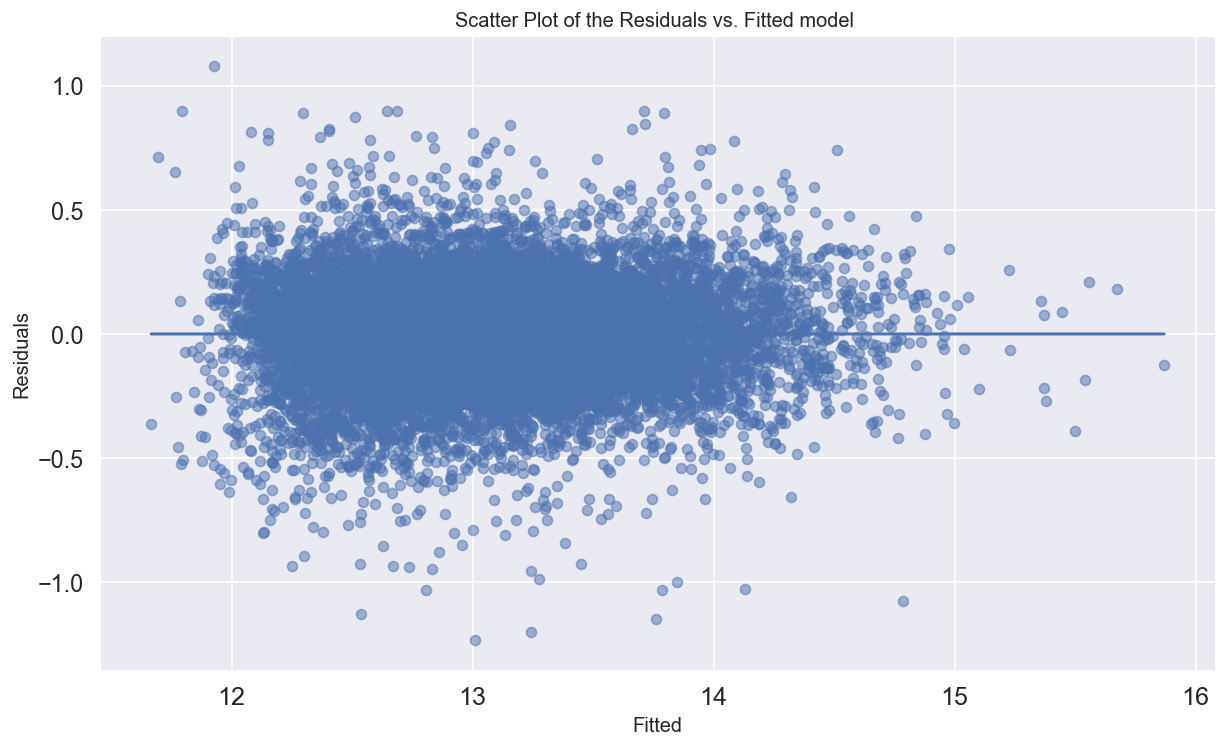

In [27]:
plt.figure(figsize=(12, 7), dpi= 120,  edgecolor='k');
plt.scatter(model.predict(df_feats[x_cols]), model.resid, alpha=0.5);
plt.plot(model.predict(df_feats[x_cols]), [0 for i in range(len(df_feats))]);
plt.gca().set(xlabel='Fitted', ylabel='Residuals',title='Scatter Plot of the Residuals vs. Fitted model ')
plt.xticks(fontsize=15); plt.yticks(fontsize=14);
plt.show();

### Checking for multicollinearity
Variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. It means that if VIF value of a parameter is higher than app.5 we need to eliminate this parameter. In this model we eliminate the parameters by using stepwise selection. We double check the results via VIF.


In [28]:
X = df_feats[x_cols]

In [29]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bathrooms', 3.532810261147149),
 ('sqft_living', 24.231433043470336),
 ('sqft_lot', 7.158113982542448),
 ('sqft_above', 23.774356878239505),
 ('sqft_basement', 5.761840207226945),
 ('yr_built', 3.670114419088229),
 ('yr_renovated', 1.1577792100722712),
 ('sqft_living15', 3.2588421558226526),
 ('sqft_lot15', 7.01812132103833),
 ('bedrooms_2', 16.121409543994105),
 ('bedrooms_3', 58.36541761361933),
 ('bedrooms_4', 43.26941635682525),
 ('bedrooms_5', 11.215246388978603),
 ('bedrooms_6', 2.8059964600891782),
 ('bedrooms_7', 1.2747984536881152),
 ('bedrooms_8', 1.1108432031738542),
 ('bedrooms_9', 1.0621756000947318),
 ('bedrooms_10', 1.0260736565318946),
 ('bedrooms_11', 1.012400920121112),
 ('floors_1_5', 1.5426225469233041),
 ('floors_2_0', 4.802944047613901),
 ('floors_2_5', 1.136634471432347),
 ('floors_3_0', 1.7297572172422735),
 ('floors_3_5', 1.024651760077093),
 ('waterfront_1_0', 1.5560007001907186),
 ('view_1_0', 1.072345061489931),
 ('view_2_0', 1.1589033915180373),
 ('view_

#### Inference from the VIF values
According to the results here grade dummy variables are problematic. They have huge values which shows multicollinearity between columns. We will drop some of them after the stepwise selection. And check the VIF values again.

### K-fold Cross Validation for Refinement I

In [30]:
X = df_feats[x_cols]
y = df_feats['price']

linreg = LinearRegression()
cvs_10=cross_val_score(linreg, X, y, cv=10)
cvs_10_res_mean = round(np.mean(cvs_10),5)
cv_10_res_std = round(np.std(cvs_10),5)
print(f'Mean cross validation score for 10 fold is {cvs_10_res_mean}')
print(f'Standard deviation of the score is {cv_10_res_std}')

Mean cross validation score for 10 fold is -5.591601865806545e+20
Standard deviation of the score is 1.1252419423335599e+21


#### Inference from the C-V results
The code above gives the mean values of the results after 10 tests with different train and test splits. These values are too high and the model is overfitted.

### Perform stepwise selection

#### Stepwise selection function

There is not a built-in function in Python libraries for stepwise selection. We are going to use this function.

In [31]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [32]:
X = df_feats[x_cols]
y = df_feats['price']
result = stepwise_selection(X, y, verbose = False)
print('resulting features:')
print(result)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

resulting features:
['grade_9', 'sqft_living', 'sqft_living15', 'zipcode_98004', 'zipcode_98023', 'grade_10', 'grade_11', 'grade_8', 'grade_12', 'grade_7', 'waterfront_1_0', 'zipcode_98003', 'zipcode_98092', 'zipcode_98033', 'grade_13', 'zipcode_98058', 'zipcode_98002', 'zipcode_98032', 'zipcode_98178', 'zipcode_98040', 'zipcode_98039', 'zipcode_98112', 'zipcode_98115', 'zipcode_98103', 'zipcode_98117', 'zipcode_98199', 'zipcode_98105', 'zipcode_98119', 'zipcode_98107', 'zipcode_98116', 'zipcode_98109', 'zipcode_98122', 'zipcode_98102', 'view_4_0', 'zipcode_98136', 'zipcode_98144', 'zipcode_98052', 'zipcode_98006', 'sqft_lot', 'zipcode_98008', 'zipcode_98005', 'zipcode_98053', 'view_3_0', 'condition_5', 'zipcode_98029', 'zipcode_98126', 'zipcode_98125', 'zipcode_98034', 'zipcode_98177', 'zipcode_98007', 'zipcode_98074', 'zipcode_98075', 'sale_month_4', 'zipcode_98027', 'zipcode_98118', 'zipcode_98133', 'sqft_above', 'view_2_0', 'bathrooms', 'zipcode_98072', 'zipcode_98155', 'condition_

## Model Refinement II


We will put the resulting features to the model and drop others. After the refinement we will check three assumptions again.

In [33]:
outcome = 'price'
x_cols = ['bathrooms', 'bedrooms_2', 'bedrooms_5', 'bedrooms_6', 'bedrooms_7', 'bedrooms_9',
           'condition_2', 'condition_3', 'condition_4', 'condition_5',
           'floors_2_0', 'floors_3_0',
           'grade_10', 'grade_11', 'grade_12', 'grade_13', 'grade_5', 'grade_7', 'grade_8', 'grade_9',
           'sale_month_2', 'sale_month_3', 'sale_month_4', 'sale_month_5',
           'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
           'view_1_0', 'view_2_0', 'view_3_0', 'view_4_0',
           'waterfront_1_0', 'yr_renovated', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004',
           'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
           'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98023', 'zipcode_98024',
           'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98032', 'zipcode_98033',
           'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98045',
           'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
           'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
           'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103', 
           'zipcode_98105', 'zipcode_98106', 'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 
           'zipcode_98112', 'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118', 
           'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 'zipcode_98126', 'zipcode_98133',
           'zipcode_98136', 'zipcode_98144', 'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 
           'zipcode_98166', 'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188', 
           'zipcode_98199']
          

#### Fitting the model

In [34]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_feats).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1691.
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        21:34:50   Log-Likelihood:                 6777.3
No. Observations:               21594   AIC:                        -1.335e+04
Df Residuals:                   21493   BIC:                        -1.255e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.1519      0.034    359.493      0.000      12.086      12.218
bathrooms          0.0284      0.002     13.080      0.000       0.024       0.033
bedrooms_2         0.0218      0.004      5.148      0.000       0.014       0.030
bedrooms_5        -0.0188      0.005     -3.815      0.000      -0.028      -0.009
bedrooms_6        -0.0499      0.011     -4.478      0.000      -0.072      -0.028
bedrooms_7        -0.1571      0.029     -5.397      0.000      -0.214      -0.100
bedrooms_9        -0.2143      0.073     -2.937      0.003      -0.357      -0.071
condition_2        0.1470      0.036      4.103      0.000       0.077       0.217
condition_3        0.2801      0.033      8.401      0.000       0.215       0.345
condition_4        0.3234      0.033      9.692      0.000       0.258       0.389
condition_5        0.3939      0.034     11.735      0.000       0.328       0.460
floors_2_0        -0.0151      0.004     -3.919      0.000      -0.023      -0.008
floors_3_0        -0.0855      0.009     -9.743      0.000      -0.103      -0.068
grade_10           0.3549      0.009     38.480      0.000       0.337       0.373
grade_11           0.4681      0.012     37.577      0.000       0.444       0.493
grade_12           0.5968      0.021     27.866      0.000       0.555       0.639
grade_13           0.8510      0.051     16.716      0.000       0.751       0.951
grade_5           -0.0645      0.012     -5.262      0.000      -0.088      -0.040
grade_7            0.0681      0.005     14.033      0.000       0.059       0.078
grade_8            0.1493      0.006     25.300      0.000       0.138       0.161
grade_9            0.2641      0.007     35.610      0.000       0.250       0.279
sale_month_2       0.0276      0.005      5.245      0.000       0.017       0.038
sale_month_3       0.0527      0.004     12.042      0.000       0.044       0.061
sale_month_4       0.0736      0.004     18.125      0.000       0.066       0.082
sale_month_5       0.0163      0.004      4.147      0.000       0.009       0.024
sqft_above         0.0826      0.006     14.475      0.000       0.071       0.094
sqft_basement      0.0135      0.003      4.678      0.000       0.008       0.019
sqft_living        0.0971      0.006     16.796      0.000       0.086       0.108
sqft_living15      0.0492      0.002     22.746      0.000       0.045       0.053
sqft_lot           0.0655      0.003     20.508      0.000       0.059       0.072
sqft_lot15        -0.0180      0.003     -5.639      0.000      -0.024      -0.012
view_1_0           0.1127      0.010     11.186      0.000       0.093       0.132
view_2_0           0.1014      0.006     16.523      0.000       0.089       0.113
view_3_0           0.1740      0.008     20.848      0.000       0.158       0.190
view_4_0    

#### Inference from the model summary
The model is powerful now. It has a high R-squared and adjusted R-squared values. All of the p-values are less than 0.05.

### Checking for Normality


We should check to ensure that our residuals are normally distributed.Q-Q plots are helpful for analyzing normality.

In [35]:
X = df_feats[x_cols]

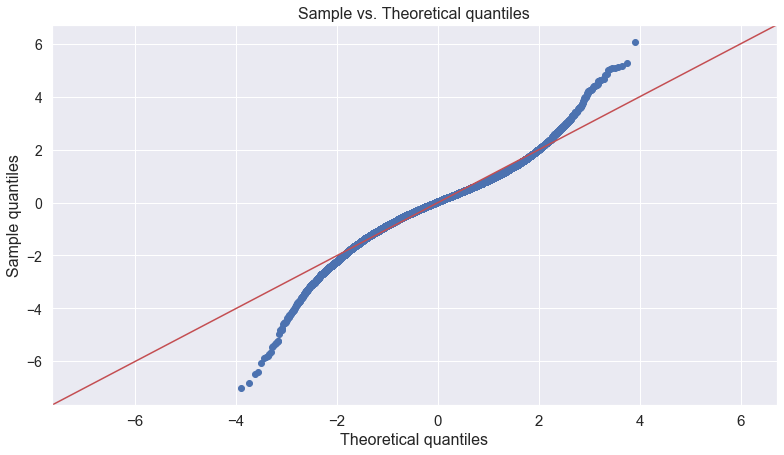

In [36]:
fig, ax = plt.subplots(figsize=(13, 7))
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax)
plt.xlabel('Theoretical quantiles', fontsize=16)
plt.ylabel('Sample quantiles', fontsize=16)
plt.title('Sample vs. Theoretical quantiles', fontsize=16)
plt.xticks(fontsize=15);
plt.yticks(fontsize=14);
plt.show();

#### Infering the Q-Q plot
There is a small change in the new model. It means the residuals does not have a perfect normal distribution. But the residuals are not very far from the theoretical values.

### Checking for Homoscedasticity

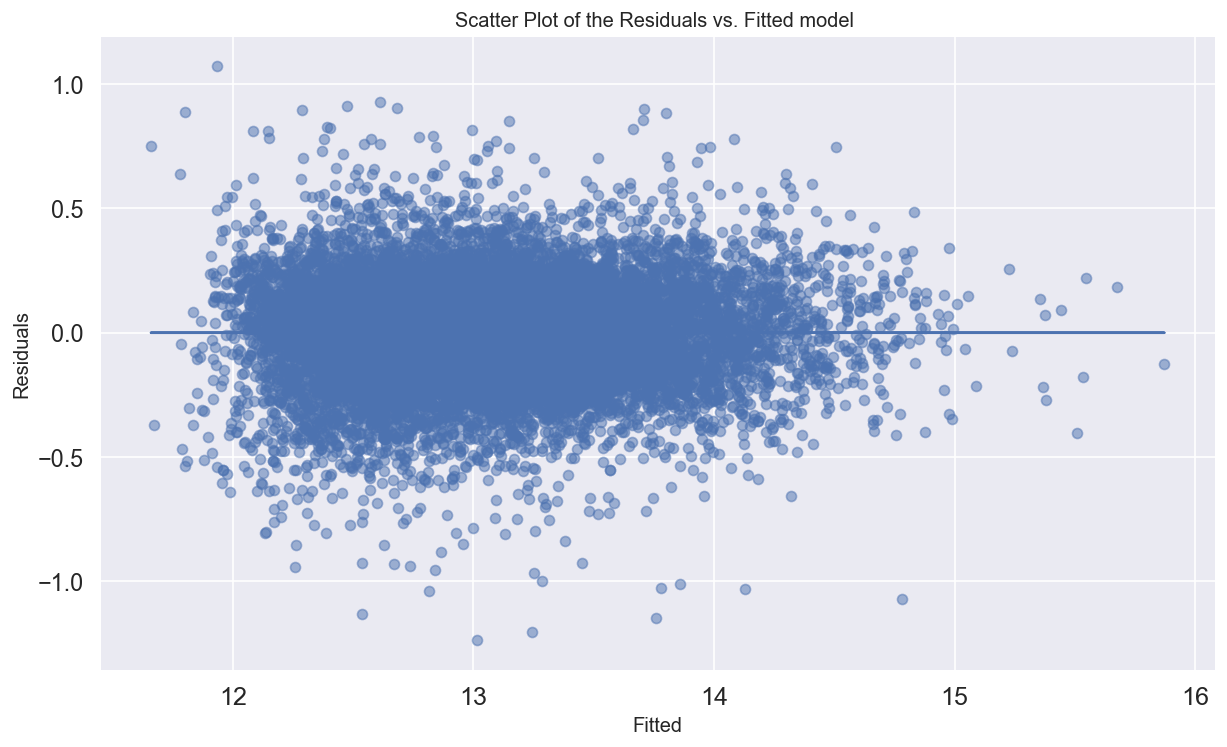

In [37]:
plt.figure(figsize=(12, 7), dpi= 120,  edgecolor='k');
plt.scatter(model.predict(df_feats[x_cols]), model.resid, alpha=0.5);
plt.plot(model.predict(df_feats[x_cols]), [0 for i in range(len(df_feats))]);
plt.gca().set(xlabel='Fitted', ylabel='Residuals',title='Scatter Plot of the Residuals vs. Fitted model ')
plt.xticks(fontsize=15); plt.yticks(fontsize=14);
plt.show();

The distribution of residuals did not change a lot after the refinement.

### Checking for Multicollinearity

In [38]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bathrooms', 3.2293532779131082),
 ('bedrooms_2', 1.5818679802079834),
 ('bedrooms_5', 1.233571383075709),
 ('bedrooms_6', 1.0771440570172675),
 ('bedrooms_7', 1.0248504616203638),
 ('bedrooms_9', 1.017006448111189),
 ('condition_2', 1.2110867590748284),
 ('condition_3', 19.381578671166217),
 ('condition_4', 7.958091248645534),
 ('condition_5', 3.026070459600657),
 ('floors_2_0', 3.9034963561356872),
 ('floors_3_0', 1.498597200827449),
 ('grade_10', 3.0587782363589837),
 ('grade_11', 1.956951422532606),
 ('grade_12', 1.2988540767523384),
 ('grade_13', 1.0726682260192888),
 ('grade_5', 1.1416619156979113),
 ('grade_7', 6.662954601294728),
 ('grade_8', 6.669520226674255),
 ('grade_9', 4.552862382039483),
 ('sale_month_2', 1.097369432863732),
 ('sale_month_3', 1.1422975385969942),
 ('sale_month_4', 1.168729305614694),
 ('sale_month_5', 1.180146810808766),
 ('sqft_above', 22.379975885242615),
 ('sqft_basement', 5.717139338746821),
 ('sqft_living', 23.00080254289665),
 ('sqft_living15', 3

#### Inference from the  VIF values
VIF values are not too high like the first model. Stepwise selection decreased the values.

### K-fold Cross Validation for Refinement

In [39]:
linreg = LinearRegression()
cvs_10=cross_val_score(linreg, X, y, cv=10)
cvs_10_res_mean = round(np.mean(cvs_10),5)
cv_10_res_std = round(np.std(cvs_10),5)
print(f'Mean cross validation score for 10 fold is {cvs_10_res_mean}')
print(f'Standard deviation of the score is {cv_10_res_std}')


Mean cross validation score for 10 fold is 0.88453
Standard deviation of the score is 0.00309


The code above gives the mean values of the results after 10 tests with different train and test splits.

## Model Refinement III

In [40]:
outcome = 'price'
x_cols = ['bathrooms', 'bedrooms_2', 'bedrooms_5', 'bedrooms_6', 'bedrooms_7', 'bedrooms_9',
           'condition_2', 'condition_3', 'condition_4', 'condition_5',
           'floors_2_0', 'floors_3_0',
           'grade_10', 'grade_11', 'grade_12', 'grade_13', 'grade_5', 'grade_7', 'grade_8', 'grade_9',
           'sale_month_2', 'sale_month_3', 'sale_month_4', 'sale_month_5',
           'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
           'view_1_0', 'view_2_0', 'view_3_0', 'view_4_0',
           'waterfront_1_0', 'yr_renovated', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004',
           'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
           'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98023', 'zipcode_98024',
           'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98032', 'zipcode_98033',
           'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98045',
           'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
           'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
           'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103', 
           'zipcode_98105', 'zipcode_98106', 'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 
           'zipcode_98112', 'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118', 
           'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 'zipcode_98126', 'zipcode_98133',
           'zipcode_98136', 'zipcode_98144', 'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 
           'zipcode_98166', 'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188', 
           'zipcode_98199']
          

In [41]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_feats).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     1690.
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        21:35:06   Log-Likelihood:                 6672.6
No. Observations:               21594   AIC:                        -1.315e+04
Df Residuals:                   21494   BIC:                        -1.235e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.1427      0.034    357.555      0.000      12.076      12.209
bathrooms          0.0295      0.002     13.528      0.000       0.025       0.034
bedrooms_2         0.0199      0.004      4.660      0.000       0.012       0.028
bedrooms_5        -0.0203      0.005     -4.100      0.000      -0.030      -0.011
bedrooms_6        -0.0495      0.011     -4.418      0.000      -0.071      -0.028
bedrooms_7        -0.1532      0.029     -5.240      0.000      -0.211      -0.096
bedrooms_9        -0.1997      0.073     -2.724      0.006      -0.343      -0.056
condition_2        0.1512      0.036      4.201      0.000       0.081       0.222
condition_3        0.2815      0.034      8.402      0.000       0.216       0.347
condition_4        0.3232      0.034      9.640      0.000       0.257       0.389
condition_5        0.3905      0.034     11.578      0.000       0.324       0.457
floors_2_0        -0.0035      0.004     -0.925      0.355      -0.011       0.004
floors_3_0        -0.0782      0.009     -8.880      0.000      -0.095      -0.061
grade_10           0.3708      0.009     40.298      0.000       0.353       0.389
grade_11           0.4897      0.012     39.407      0.000       0.465       0.514
grade_12           0.6227      0.021     29.035      0.000       0.581       0.665
grade_13           0.8988      0.051     17.606      0.000       0.799       0.999
grade_5           -0.0668      0.012     -5.422      0.000      -0.091      -0.043
grade_7            0.0695      0.005     14.262      0.000       0.060       0.079
grade_8            0.1554      0.006     26.274      0.000       0.144       0.167
grade_9            0.2747      0.007     37.047      0.000       0.260       0.289
sale_month_2       0.0268      0.005      5.071      0.000       0.016       0.037
sale_month_3       0.0529      0.004     12.028      0.000       0.044       0.062
sale_month_4       0.0737      0.004     18.062      0.000       0.066       0.082
sale_month_5       0.0156      0.004      3.954      0.000       0.008       0.023
sqft_basement     -0.0214      0.002    -13.500      0.000      -0.025      -0.018
sqft_living        0.1702      0.003     59.888      0.000       0.165       0.176
sqft_living15      0.0500      0.002     22.998      0.000       0.046       0.054
sqft_lot           0.0677      0.003     21.124      0.000       0.061       0.074
sqft_lot15        -0.0192      0.003     -6.004      0.000      -0.025      -0.013
view_1_0           0.1145      0.010     11.316      0.000       0.095       0.134
view_2_0           0.1016      0.006     16.487      0.000       0.090       0.114
view_3_0           0.1738      0.008     20.716      0.000       0.157       0.190
view_4_0           0.2919      0.013     22.925      0.000       0.267       0.317
waterfront_1

In [42]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bathrooms', 3.2293532779131082),
 ('bedrooms_2', 1.5818679802079834),
 ('bedrooms_5', 1.233571383075709),
 ('bedrooms_6', 1.0771440570172675),
 ('bedrooms_7', 1.0248504616203638),
 ('bedrooms_9', 1.017006448111189),
 ('condition_2', 1.2110867590748284),
 ('condition_3', 19.381578671166217),
 ('condition_4', 7.958091248645534),
 ('condition_5', 3.026070459600657),
 ('floors_2_0', 3.9034963561356872),
 ('floors_3_0', 1.498597200827449),
 ('grade_10', 3.0587782363589837),
 ('grade_11', 1.956951422532606),
 ('grade_12', 1.2988540767523384),
 ('grade_13', 1.0726682260192888),
 ('grade_5', 1.1416619156979113),
 ('grade_7', 6.662954601294728),
 ('grade_8', 6.669520226674255),
 ('grade_9', 4.552862382039483),
 ('sale_month_2', 1.097369432863732),
 ('sale_month_3', 1.1422975385969942),
 ('sale_month_4', 1.168729305614694),
 ('sale_month_5', 1.180146810808766),
 ('sqft_basement', 22.379975885242615),
 ('sqft_living', 5.717139338746821),
 ('sqft_living15', 23.00080254289665),
 ('sqft_lot', 3.2

In [43]:
linreg = LinearRegression()
cvs_10=cross_val_score(linreg, X, y, cv=10)
cvs_10_res_mean = round(np.mean(cvs_10),5)
cv_10_res_std = round(np.std(cvs_10),5)
print(f'Mean cross validation score for 10 fold is {cvs_10_res_mean}')
print(f'Standard deviation of the score is {cv_10_res_std}')


Mean cross validation score for 10 fold is 0.88453
Standard deviation of the score is 0.00309


In [44]:
Mean cross validation score for 10 fold is 0.88453
Standard deviation of the score is 0.00309
​

SyntaxError: invalid syntax (<ipython-input-44-0e421f840f0f>, line 1)

#### Note

First I decided not to use the date column to predict the price of a house. After I finished all the project I tried adding the month which the house was sold to see if it makes the model better. And it worked! R-squared value increased and standard deviation decreased.

These are the 10-fold Cross Validation results before I added the sale month by one hot encoding:

Mean cross validation score for 10 fold is 0.88227 and standard deviation of the score is 0.00346

Difference in the R quared values of both models: 0.88453 - 0.88227 = 0.00226

Difference in the standard deviation of both models: 0.00346 - 0.00309 = 0.00037


There is a small difference between two models but I think it worths to add date to the parameters.


# iNterpreting the data


## Answers to the Questions 

### 1) Key factors to predict the price of a house: 

The key factors affecting the price of a house are square feet of living and location. This can be seen from the pairplot above and boxplot below. In fact there are many factors to predict the price of a house. In King county housing data set we are given 17 factors to predict the price. Home buying or selling is too complicated that only 17 parameters won't give you the price of the house. Our models success is 88.453% which means we have information about the main factors to predict the price but we don't have the details. 

The factors in the last model are square footages(basement, lot and living area of the house and living and lot area of the neighbors), bedrooms, bathrooms, construction quality, renovations, view of the house, location of the house and the month house was sold.

We can have more success if we have information about the following:

Some details about grade and condition columns(Roof, AC, kitchen and bathrooms) 

The size and the condition of the garden (Every big tree adds 10K to the value)

Deck and/or patio

Energy efficiency of the house

There are some factors which we can not control. These are economic indicators and interest rates and the local market. 

We were given 20 parameters but to make a succussful prediction we need approximayetely 5 parameters about each parameter. For example, we know only the square feet of basement but we need general condition of the basement, Quality of basement finished area,Unfinished square feet of basement area, Walkout or garden level basement walls.

Predicting the price of a house requires approximetely 100 parameters.

### 2) The most important factor determining the value of a house
   

Location! Location! Location!

In the beginning I did not plan to use all zipcode columns because I thought adding 70 more columns to 40 columns would increase the R-squared value but decrease the adjusted-R-squared value. But I realised that sample size was too big. According to the mathematical formula more than 100 columns was not going to be a problem for adjusted-R-squared. After adding zip codes as dummy variables the pridictive power of my model increased a lot. I understood that the most importing prediction factor for the price of a house is location. I wanted to go further to see why some regions are more expensive.

In [ ]:
income_df=pd.read_csv('king_county_dataset_cleaned.csv')

In [ ]:
from uszipcode import SearchEngine, Zipcode

In [ ]:
search = SearchEngine(simple_zipcode=False)

In [ ]:
def zco(x):
    '''
    Takes the given zip code parameter and returns the median house income of this area.
    
    '''
    income = search.by_zipcode(x)
    
    return income.median_household_income if income else x
   

In [ ]:
income_df['income'] = income_df['zipcode'].astype(int).astype(str).apply(zco)

In [ ]:
income_df.head()

In [ ]:
fig = plt.figure(figsize = (20,8));
fig = sns.boxplot(x='zipcode', y='price', data=income_df, showfliers = False);
plt.title('Prices of Houses Sold in King County by Zip Code',fontsize=18);
plt.xlabel("Zip Code", fontsize=18);
plt.xticks(rotation=90);
plt.ylabel('Sale Price, $', fontsize=18);
plt.show();


https://www.zillow.com/bellevue-wa-98004/

https://www.zillow.com/mercer-island-wa-98040/

https://www.zillow.com/medina-wa-98039/

https://www.zillow.com/seattle-wa-98112/

In [ ]:
high_price_zipcodes=[98040,98004,98039,98112]
for i in high_price_zipcodes:
    zipcode = search.by_zipcode(i)
    income=zipcode.median_household_income
    density=zipcode.population_density
    
    print('Zip code:',i ,'-------   Median household income of all the houses in this zipcode:' ,income)

In [ ]:
zipcode = search.by_zipcode(78240)
race=zipcode.population_by_race
race

In [ ]:
zipcode = search.by_zipcode(78240)
zipcode

### 3) Home improvements

Columns in the data set:

date - Date house was sold

price - Price is prediction target

bedrooms - Number of Bedrooms/House

bathrooms - Number of bathrooms/bedrooms

sqft_living - Square footage of the home

sqft_lot - Square footage of the lot

floors - Total floors (levels) in house

waterfront - House which has a view to a waterfront

view - If the house has a view or not

condition - How good the condition is ( Overall )

grade - overall grade given to the housing unit, based on King County grading system

sqft_above - square footage of house apart from basement

sqft_basement - square footage of the basement

yr_built - Built Year

yr_renovated - Year when house was renovated

zipcode - zipcode of the house

lat - Latitude coordinate

long - Longitude coordinate

sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors

sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors


Some of these columns can not be changed after you buy a house. For example you can not change the location. Columns dependent of the location are: Latitude, Longitude,Zip code, The square footage of interior housing living space for the nearest 15 neighbors, The square footage of the land lots of the nearest 15 neighbors etc. You can not change total floors (levels) in house. 

View and waterfront also can not be changed but some improvements can be made to them. For example, a deck can be made to have a better view. A pool can be made to have a waterfront like view.

There are some columns in the dataset that we can change.Bedrooms, bathrooms,year renovated,date the house was sold  We can have more bedrooms by renovating an attic, we can have a half bathroom by converting a closet into a bathroom, you can change the finished area of the basement. Replacing the entry door or garage door, minor kitchen remodeling, adding a wooden deck, upscale siding replacement also return the money you invest for renovations.



In [ ]:
income_df.columns